# Exploring the IEQ Dataset
Looking for relationship between the IEQ variables measured by the beacons.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from src.visualization import visualize

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap

import seaborn as sns

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
import math
from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime, timedelta

# Data Import
We want all the measurements made by the beacon - not just the nightly concentrations.

In [2]:
data = pd.read_csv("../data/processed/beacon-ux_s20.csv", parse_dates=["timestamp"],index_col="timestamp",infer_datetime_format=True)
# dropping the unecessary id columns
data.drop(["beiwe","fitbit","redcap","no2"],axis="columns",inplace=True)

# Helper Functions
Some helpful functions that we will probably call from time to time.

In [3]:
def scale_data(df):
    """scales the data in each column between 0 and 1 based on min-max"""
    scaler = MinMaxScaler()
    for col in df.columns:
        try:
            df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        except ValueError:
            pass
        
    return df

In [4]:
def get_beacon(df,bb):
    """gets data specific to the given beacon"""
    return df[df["beacon"] == bb]

In [5]:
def get_timing(s_time,e_time):
    """gets the seconds between the two time periods"""
    return round((e_time - s_time).total_seconds(),1)

In [6]:
def resample_data(df,minutes):
    """resamples the data to the given frequency"""
    if isinstance(df.index,pd.DatetimeIndex):
        return df.resample(f"{minutes}T").mean()
    else:
        try:
            df.set_index("timestamp",inplace=True)
            return df.resample(f"{minutes}T").mean()
        except KeyError:
            print("Need to set index as datetime")
            return df

# Relationship Analysis with MIC
Using this fancy idea of Maximual Information Coefficient, we can look at which variables are the most closely related.

In [7]:
def get_mic(df,xlabel,ylabel):
    """gets the MIC score between the two variables"""
    x = df[xlabel].values
    y = df[ylabel].values
    
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(x,y)
    score = mine.mic()
    
    return score

## Per Beacon
We start with the analysis per beacon.

In [10]:
def get_mic_per_beacon(df,params=["tvoc","co","co2","pm2p5_mass","temperature_c","rh"]):
    """gets the MIC score for each relationship in params for each beacon"""
    res = {"beacon":[],"param1":[],"param2":[],"mic":[]} # dict to store results
    for bb in df["beacon"].unique():
        print("Running for Beacon",bb,end="")
        s = datetime.now()
        data_by_beacon = get_beacon(df,bb).dropna()
        data_by_beacon = resample_data(data_by_beacon,10)
        index = 1 # so we don't double-count relationships
        for p1 in params:
            for p2 in params[index:]:
                score = get_mic(data_by_beacon,p1,p2)
                # appending results to dict
                for key, val in zip(res.keys(),[bb,p1,p2,score]):
                    res[key].append(val)
                print(".",end="")

            index += 1
        e = datetime.now()
        print("\tTime to Complete:",get_timing(s,e))
            
    return pd.DataFrame(res)

In [11]:
results_per_beacon = get_mic_per_beacon(data)

Running for Beacon 1...............	Time to Complete: 19.9
Running for Beacon 5...............	Time to Complete: 63.6
Running for Beacon 6...............	Time to Complete: 0.0
Running for Beacon 7...............	Time to Complete: 87.1
Running for Beacon 10...............	Time to Complete: 69.6
Running for Beacon 11...............	Time to Complete: 20.0
Running for Beacon 15...............	Time to Complete: 36.1
Running for Beacon 16...............	Time to Complete: 2.1
Running for Beacon 17...............	Time to Complete: 54.3
Running for Beacon 19...............	Time to Complete: 47.3
Running for Beacon 21...............	Time to Complete: 113.2
Running for Beacon 22...............	Time to Complete: 46.6
Running for Beacon 24...............	Time to Complete: 48.5
Running for Beacon 25...............	Time to Complete: 79.4
Running for Beacon 26...............	Time to Complete: 72.4
Running for Beacon 28...............	Time to Complete: 0.0
Running for Beacon 29...............	Time to C

### Highest Scoring Relationship
Now that we have the results all summarized, we can see which relationships were the strongest per each beacon. Hopefully there is a trend...

In [19]:
top_results_per_beacon = results_per_beacon[["beacon","mic"]].groupby("beacon").max().merge(right=results_per_beacon,on="mic").sort_values(["param1","param2","mic"],ascending=False)
top_results_per_beacon = top_results_per_beacon[top_results_per_beacon["mic"] > 0.5]
top_results_per_beacon

,mic,beacon,param1,param2
378,0.579224,10,tvoc,co2
392,0.800651,38,tvoc,co
379,0.671946,11,tvoc,co
0,0.662209,1,tvoc,co
393,0.600230,44,temperature_c,rh
382,0.899811,17,co2,temperature_c
383,0.850172,19,co,temperature_c
384,0.722427,21,co,temperature_c
390,0.596456,34,co,temperature_c
381,0.688801,16,co,rh


<div class="alert-block alert alert-warning">
    
I am less inclined to use these results simply because they utilize so many data for each value. I am afraid some of these relationships are simply constant. 

</div>

### Aggregating Daily MIC per Beacon
The idea is to calculate a MIC for each relationship on each beacon for each day and average them which might provide more appropriate results.

In [30]:
def get_mic_per_beacon_by_day(df,params=["tvoc","co","co2","pm2p5_mass","temperature_c","rh"]):
    """gets the MIC score for each relationship in params for each beacon"""
    res = {"beacon":[],"param1":[],"param2":[],"mic":[]} # dict to store results
    for bb in df["beacon"].unique():
        s = datetime.now()
        data_by_beacon = get_beacon(df,bb)
        if len(data_by_beacon) > 1:
            print("Running for Beacon",bb,end="")
            data_by_beacon = resample_data(data_by_beacon,5)
            data_by_beacon["date"] = data_by_beacon.index.date
            index = 1 # so we don't double-count relationships
            for p1 in params:
                for p2 in params[index:]:
                    total_score = 0
                    temp = data_by_beacon.dropna(subset=[p1,p2])
                    if len(temp) > 1:
                        for d in temp["date"].unique():
                            data_by_beacon_by_day = temp[temp["date"] == d]
                            total_score += get_mic(data_by_beacon_by_day,p1,p2)
                        # appending results to dict
                        for key, val in zip(res.keys(),[bb,p1,p2,total_score/len(data_by_beacon["date"].unique())]):
                            res[key].append(val)
                        print(".",end="")
                    else:
                        print("!",end="")
                        
                index += 1
            e = datetime.now()
            print("\tTime to Complete:",get_timing(s,e))
        else:
            print("COULD NOT RUN FOR BEACON",bb)
            
    return pd.DataFrame(res)

In [31]:
results_by_day = get_mic_per_beacon_by_day(data)

Running for Beacon 1...............	Time to Complete: 4.3
Running for Beacon 5...............	Time to Complete: 7.5
Running for Beacon 6......	Time to Complete: 2.9
Running for Beacon 7...............	Time to Complete: 8.6
Running for Beacon 10...............	Time to Complete: 8.8
Running for Beacon 11...............	Time to Complete: 3.4
Running for Beacon 15...............	Time to Complete: 5.6
Running for Beacon 16...............	Time to Complete: 1.1
Running for Beacon 17...............	Time to Complete: 5.7
Running for Beacon 19...............	Time to Complete: 7.0
Running for Beacon 21...............	Time to Complete: 13.3
Running for Beacon 22...............	Time to Complete: 5.0
Running for Beacon 24...............	Time to Complete: 6.9
Running for Beacon 25...............	Time to Complete: 9.6
Running for Beacon 26...............	Time to Complete: 8.9
Running for Beacon 28...............	Time to Complete: 3.3
Running for Beacon 29...............	Time to Complete: 6.7
Running f

In [32]:
top_results_by_day = res[["beacon","mic"]].groupby("beacon").max().merge(right=res,on="mic").sort_values(["param1","param2","mic"],ascending=False)
top_results_by_day = top_results_by_day[top_results_by_day["mic"] > 0.5]
top_results_by_day

,mic,beacon,param1,param2
3,0.923093,10,tvoc,co2
17,0.837003,38,tvoc,co2
15,0.803460,34,tvoc,co2
10,0.791001,22,tvoc,co2
0,0.767234,1,tvoc,co2
14,0.712012,29,tvoc,co2
4,0.688752,11,tvoc,co2
1,0.755013,5,tvoc,co
18,0.896419,44,temperature_c,rh
7,0.840065,17,temperature_c,rh


<div class="alert-block alert alert-success">
    
There seem to be some high-scoring relationships between a few common pairings:
    
1. tvoc and co2
2. temperature and rh
3. co2 and temperature
    

</div>

In [44]:
def visualize_daily_ts(df, p1, p2):
    """plots the timeseries of both parameters for each day stacked on top of each other"""
    df = scale_data(df)
    df.dropna(subset=[p1,p2],inplace=True)
    df["date"] = df.index.date
    n = len(df["date"].unique())
    _, axes = plt.subplots(n,1,figsize=(24,2*n),sharex=True,gridspec_kw={"hspace":0})
    for d, ax in zip(df["date"].unique(),axes.flat):
        df_by_day = df[df["date"] == d]
        df_by_day.reset_index(inplace=True)
        ax.scatter(df_by_day.index,df_by_day[p1],s=10,color="black",label=visualize.get_label(p1))
        ax.scatter(df_by_day.index,df_by_day[p2],s=10,color="firebrick",label=visualize.get_label(p2))
        ax.set_ylim([0,1])
    
    plt.show()
    plt.close()

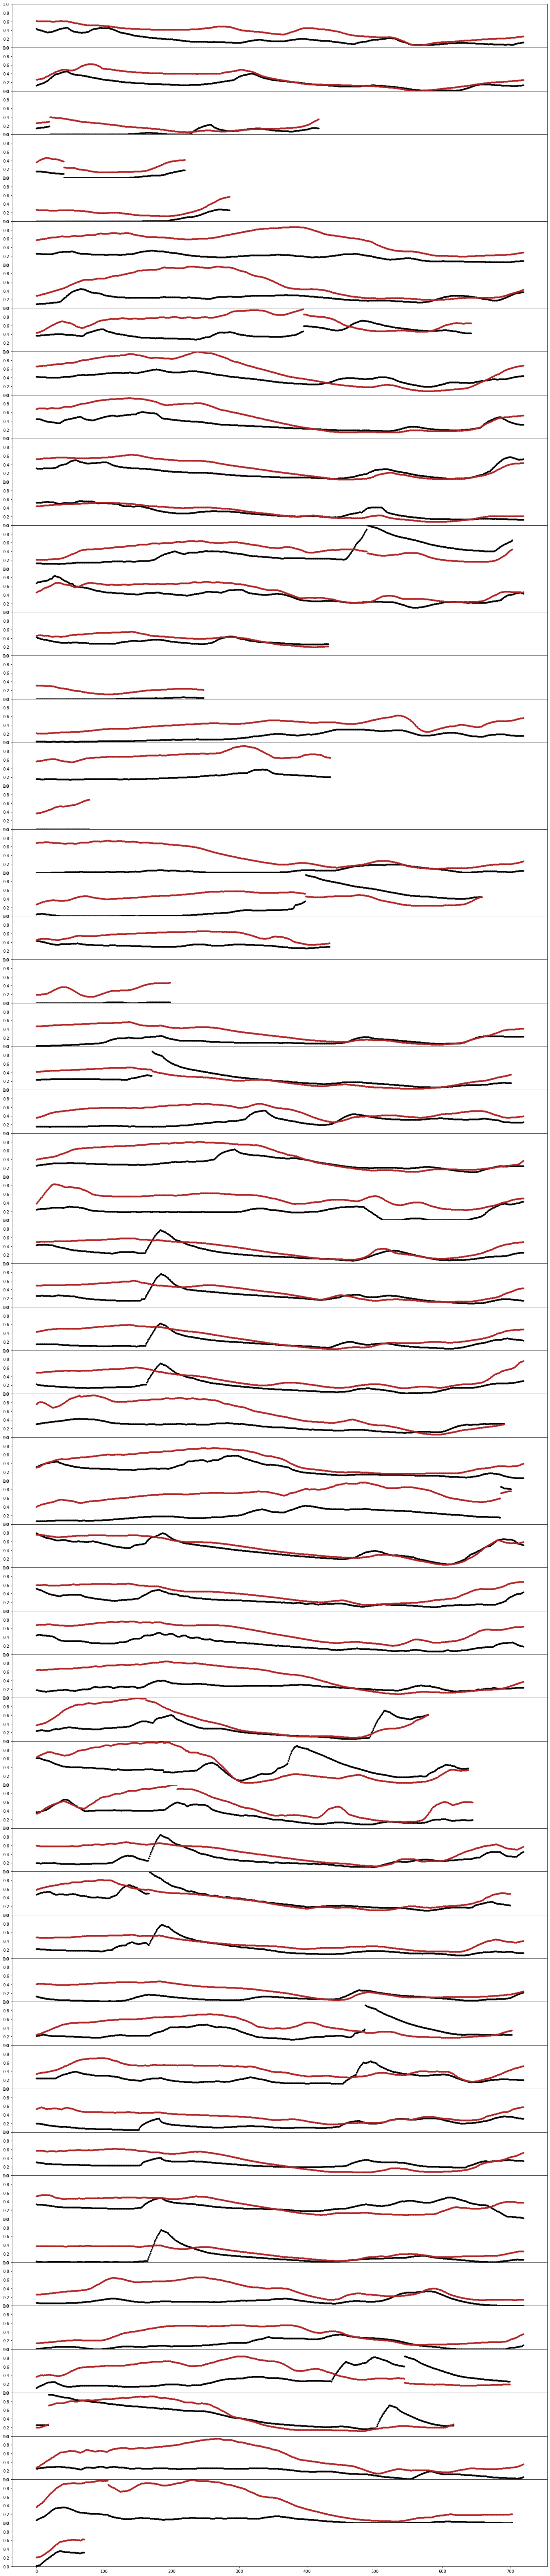

In [45]:
visualize_daily_ts(get_beacon(data,38),"tvoc","co2")